In [1]:
import alias
import alias.injection as inj
import alias.continuum_normalization as cn
import alias.detection as detect

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
from astropy.io import fits

plt.rcParams.update({'font.size': 10})

%matplotlib inline

/mnt_home/jhand/alias/alias/injection.py:30: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [2]:
with open('../data/sample_star_urls', 'r') as f:
    urls = f.read().splitlines()

exclude = []

files = [ '../data/spectra/%s' %url.split('/')[-1] for url in urls if url not in exclude]

ds = alias.loadDataset(files)

/mnt_home/jhand/alias/alias/__init__.py:59: RuntimeWarning: divide by zero encountered in power
  spec_ivar_parts = np.array(hdul[2].data)**-2
/home/jhand/.conda/envs/dev/lib/python3.11/site-packages/numpy/lib/function_base.py:551: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,


In [3]:
norm_flux, norm_ivar, _ = cn.continuum_normalize(ds.flux, ds.ivar)
residuals = norm_flux - np.nanmedian(norm_flux, axis=0)

In [4]:
detections = detect.detect_all(ds.wave, residuals, ds.ivar)

(15800.0, 15820.0)

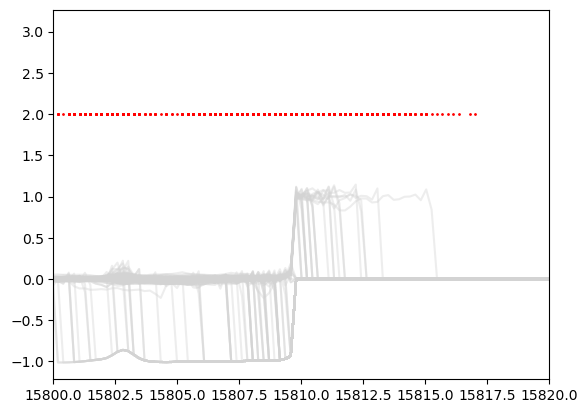

In [5]:
plt.scatter(ds.wave[detections[:,1]], [2]*len(detections), s=1, color='red')
plt.plot(ds.wave, residuals[0:100].T, alpha=0.4, color='lightgray')

plt.xlim(15800, 15820)

In [6]:
len(detections)

63170

In [7]:
hist = np.array([0]*len(ds.wave))
hist_partial = np.bincount(detections[:,1])
hist[0:len(hist_partial)] = hist_partial
mask = hist > 1

In [8]:
unique_detections = detections[~mask[detections[:,1]],:]

In [9]:
len(unique_detections)

806

In [10]:
characteristics = np.array([ detect.characterize(ds.wave, residuals[n], ds.ivar[n], peak) for n,peak in unique_detections ])

/mnt_home/jhand/alias/alias/detection.py:23: RuntimeWarning: divide by zero encountered in power
  chi2 = [ _chi2_lsf(flux, ivar**-0.5, inj.default_lsf.x, np.array(inj.default_lsf.y), 0.3, center) for center in center_idx ]
/mnt_home/jhand/alias/alias/detection.py:31: RuntimeWarning: divide by zero encountered in power
  chi2 = [ _chi2_lsf(flux, ivar**-0.5, inj.default_lsf.x, np.array(inj.default_lsf.y), amp, best_idx) for amp in amps ]


(array([ 31.,  38., 164., 241., 105.,  28.,  23.,  21.,   6.,   9.,  11.,
          9.,   5.,   5.,   2.,   9.,  25.,  10.,  12.,   9.,   9.,   8.,
          4.,   4.,   3.,   3.,   1.,   1.,   5.,   5.]),
 array([0.03967966, 0.18386996, 0.32806027, 0.47225058, 0.61644088,
        0.76063119, 0.9048215 , 1.0490118 , 1.19320211, 1.33739242,
        1.48158272, 1.62577303, 1.76996334, 1.91415365, 2.05834395,
        2.20253426, 2.34672457, 2.49091487, 2.63510518, 2.77929549,
        2.92348579, 3.0676761 , 3.21186641, 3.35605671, 3.50024702,
        3.64443733, 3.78862764, 3.93281794, 4.07700825, 4.22119856,
        4.36538886]),
 <BarContainer object of 30 artists>)

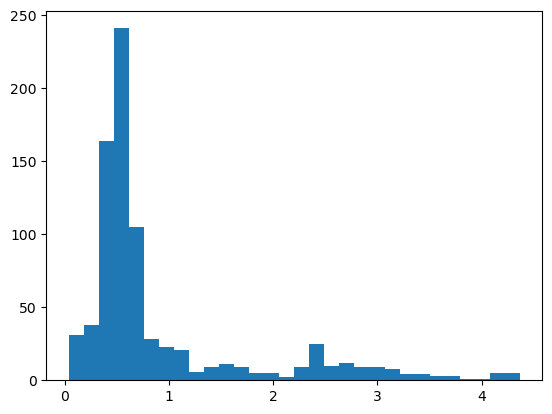

In [11]:
plt.hist(characteristics[:,2], bins=30)

In [76]:
candidates = unique_detections[(characteristics[:,2] > 0.7)]
candidate_chars = characteristics[(characteristics[:,2] > 0.7)]

print(len(candidates))

254


/tmp/ipykernel_4030799/2487847800.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12,8))


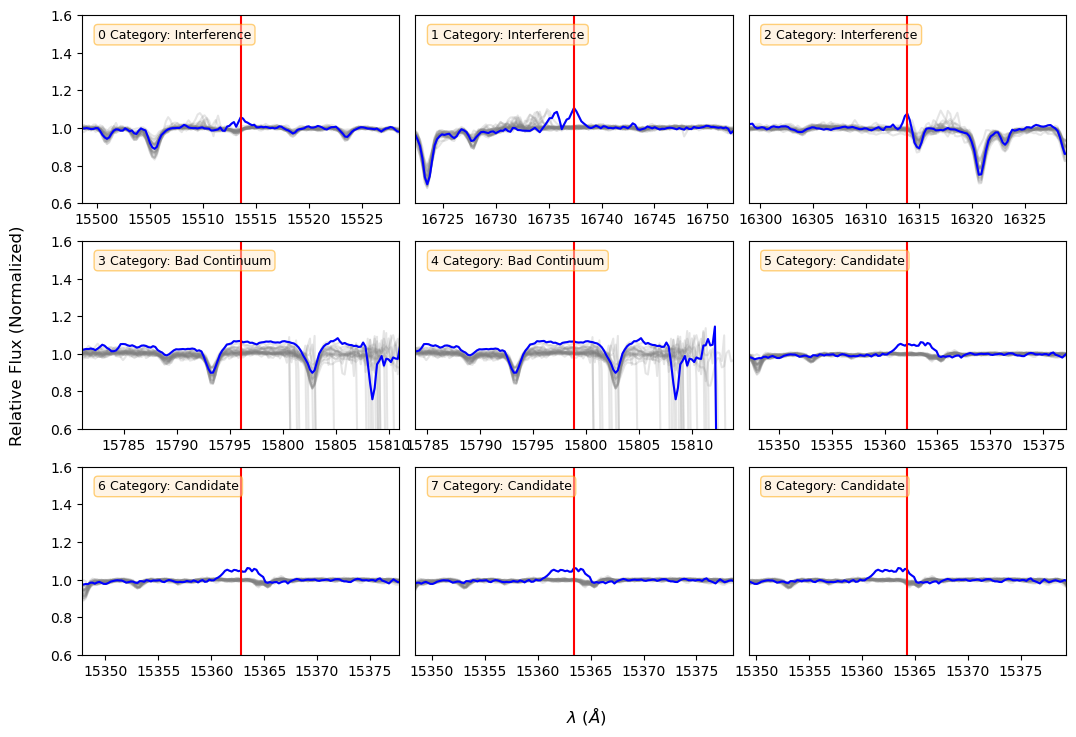

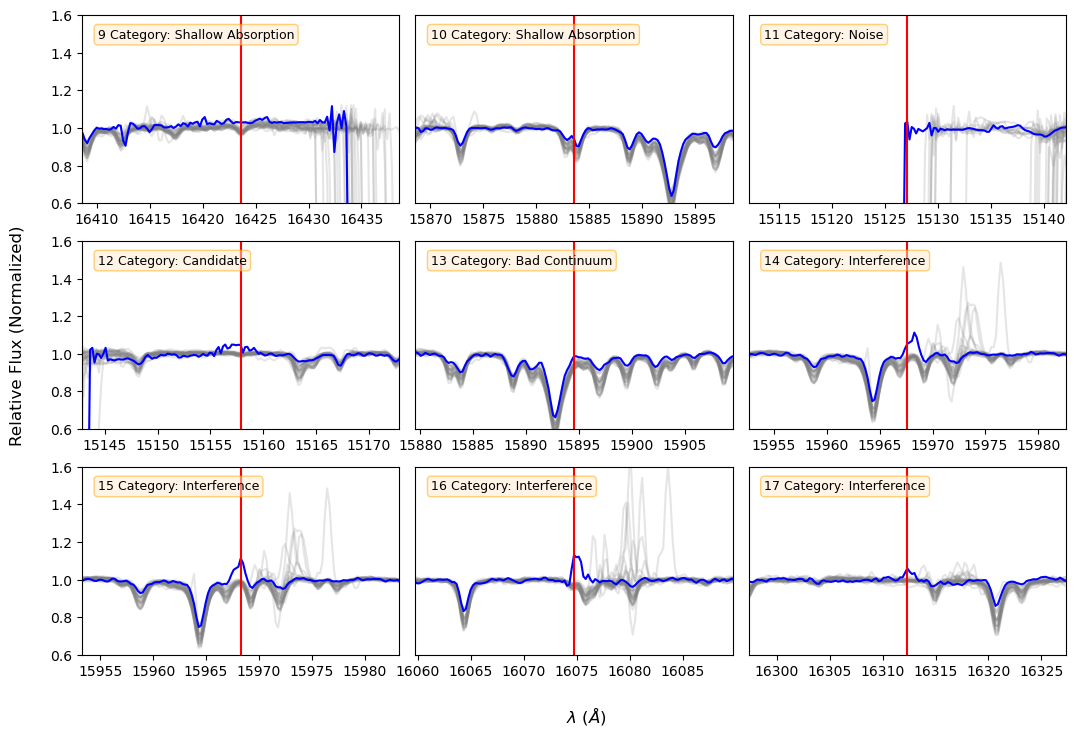

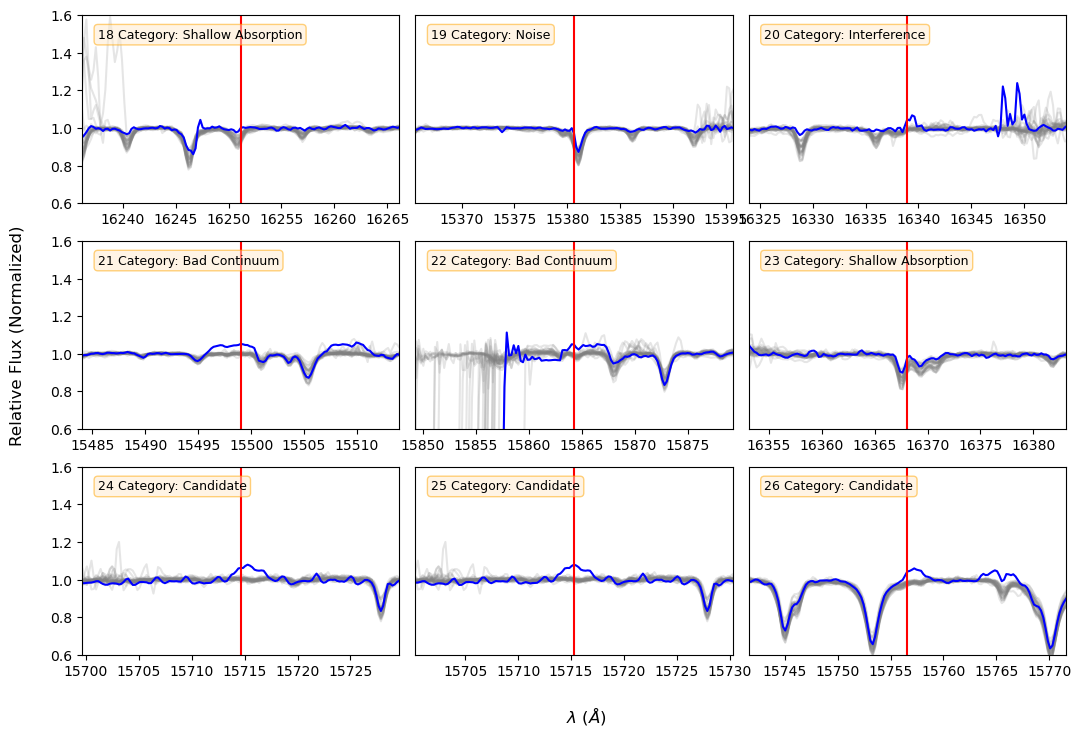

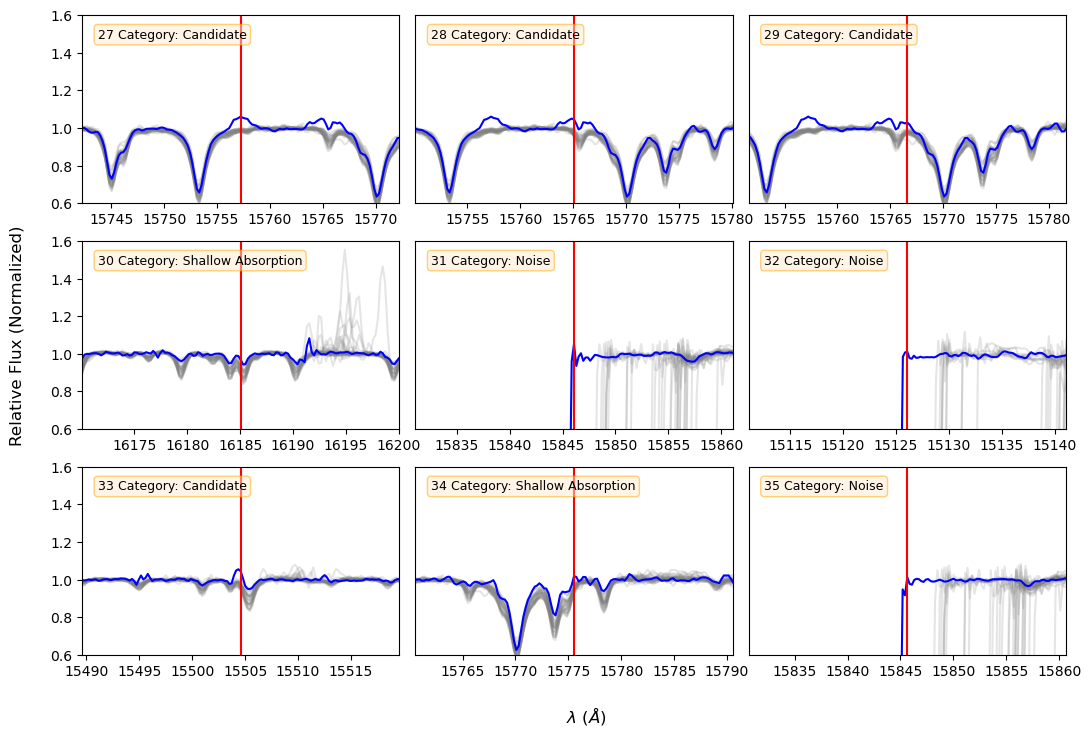

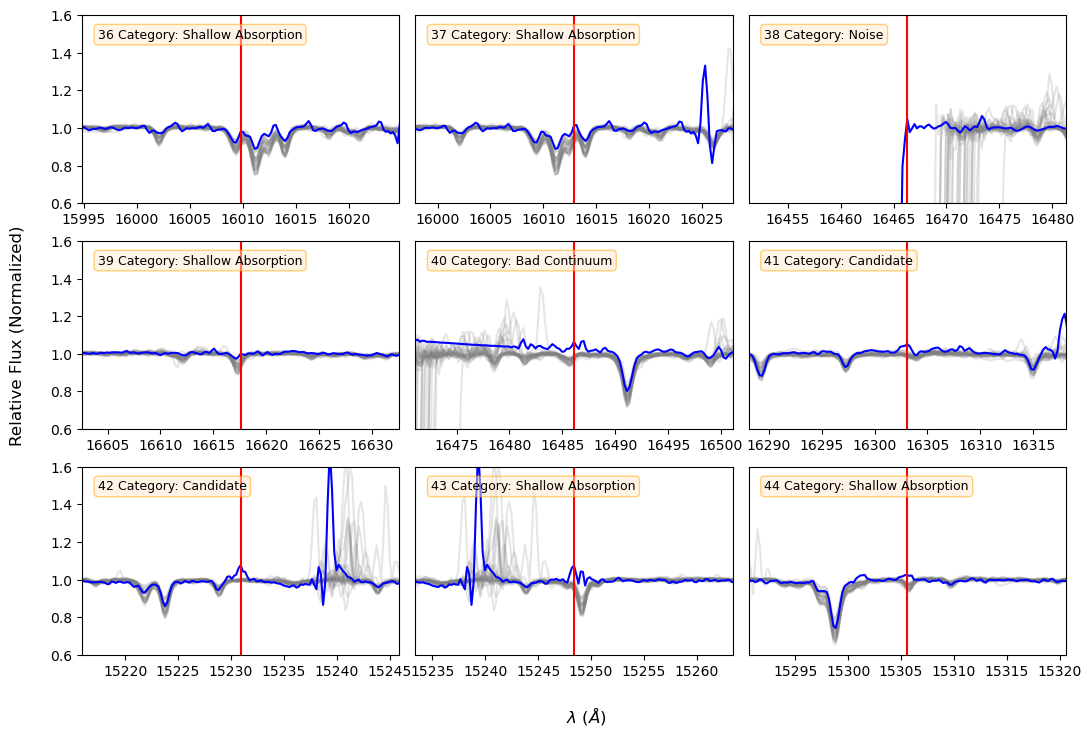

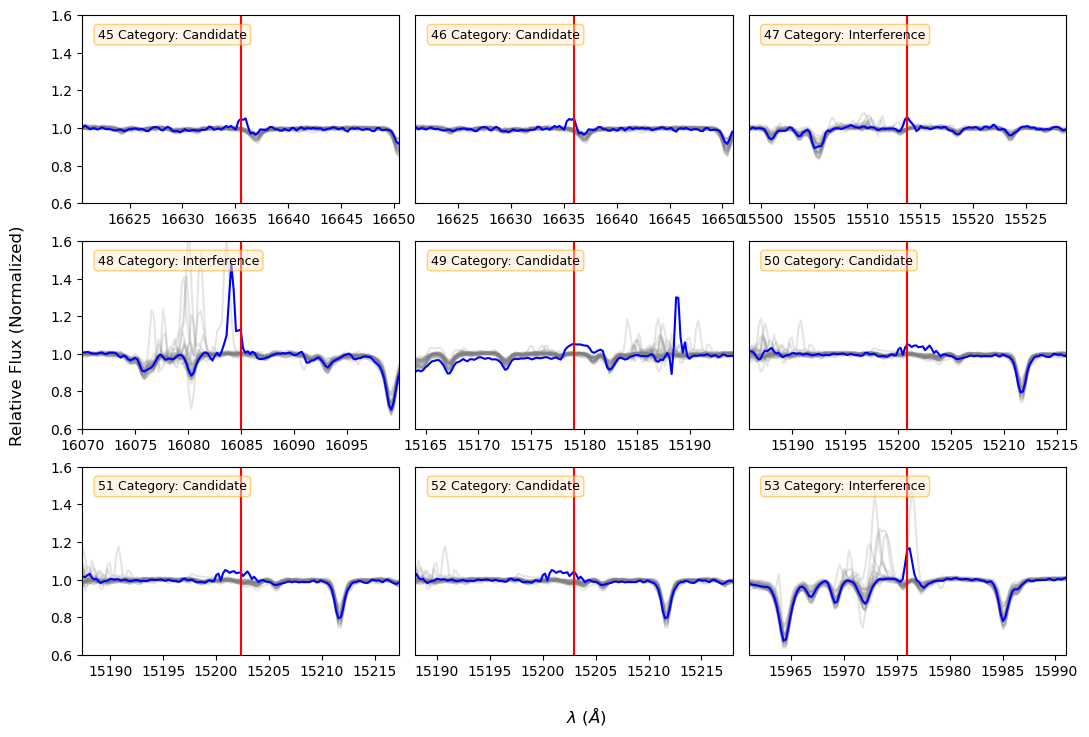

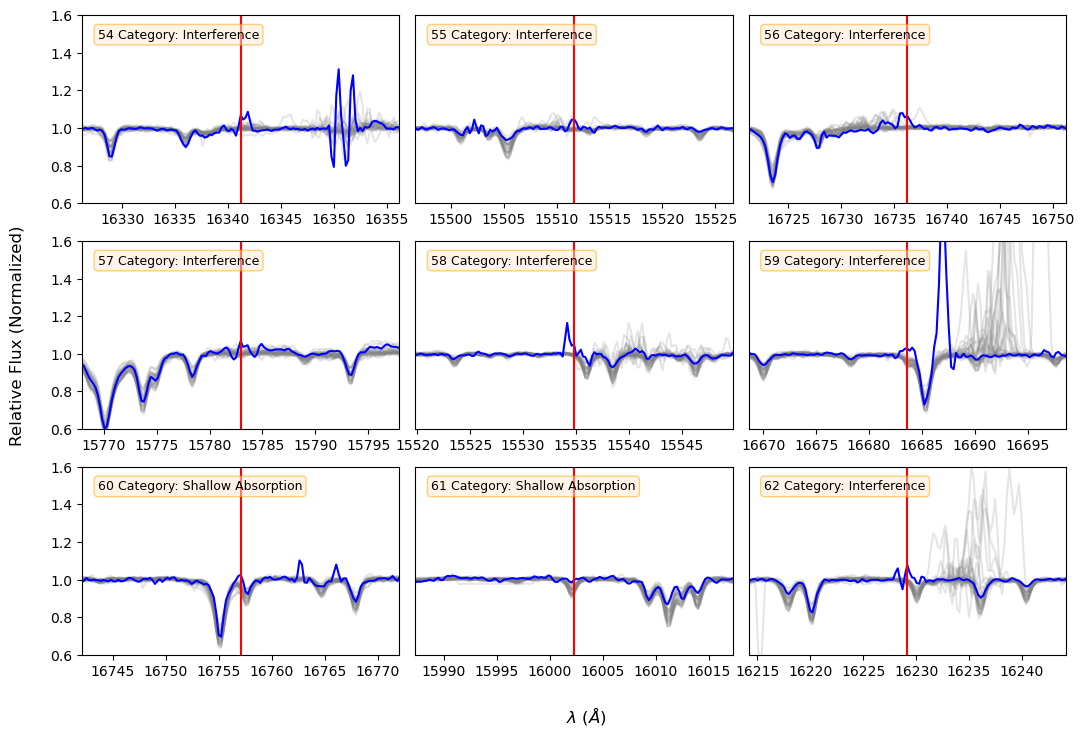

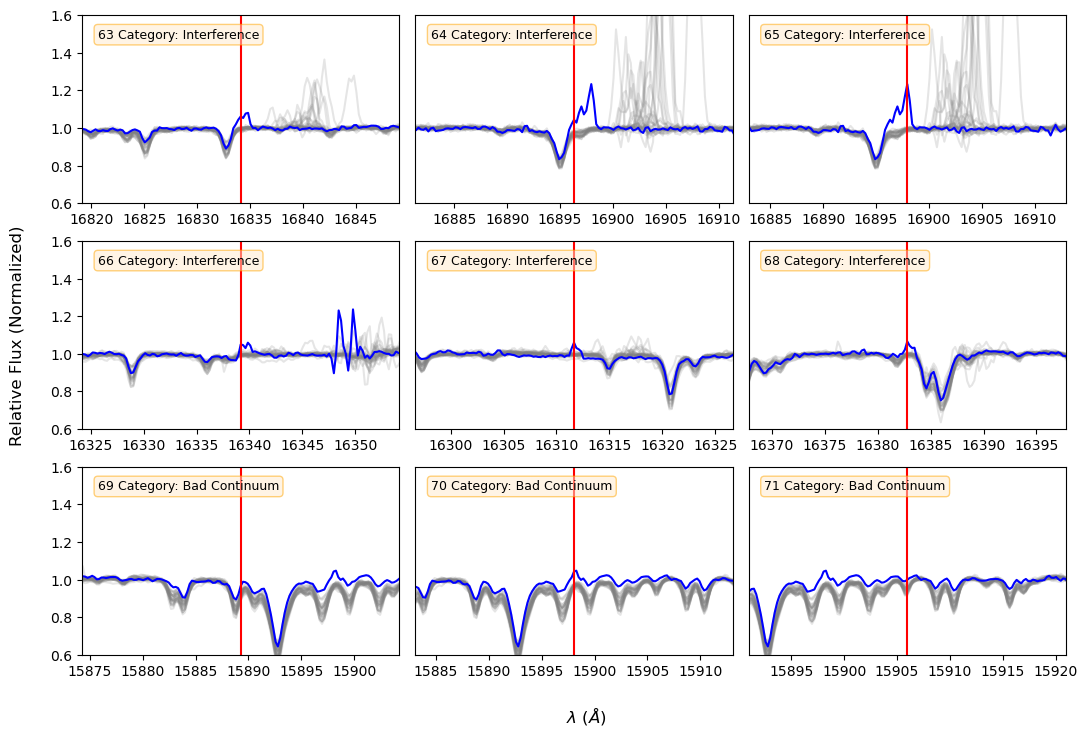

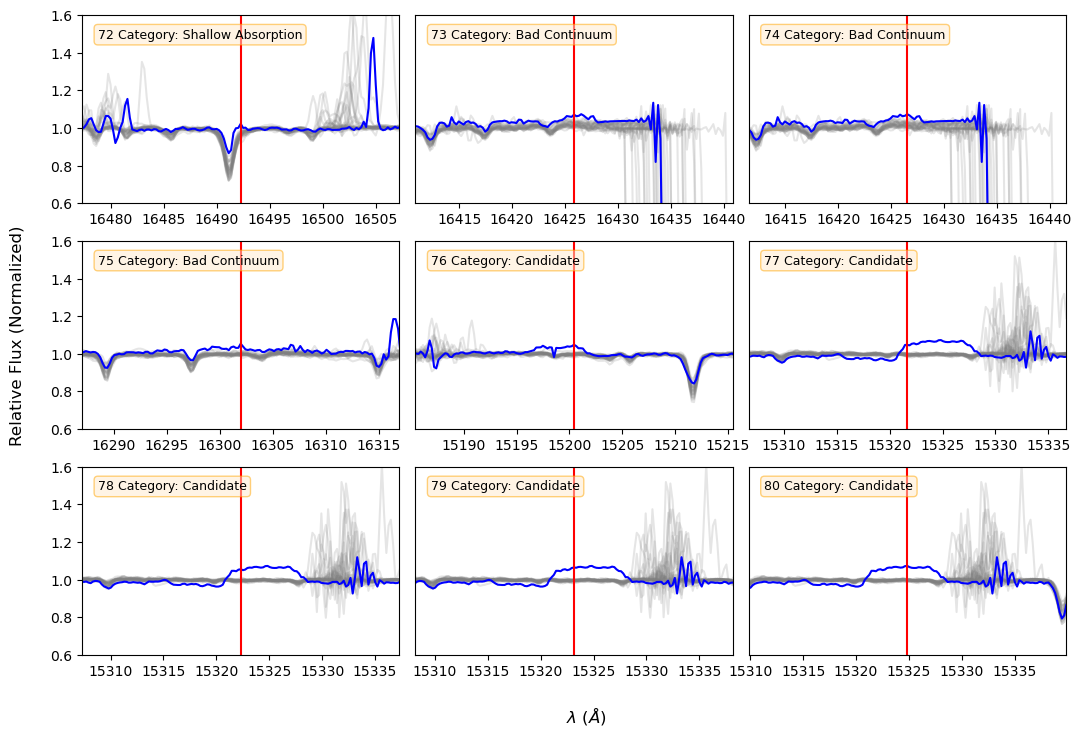

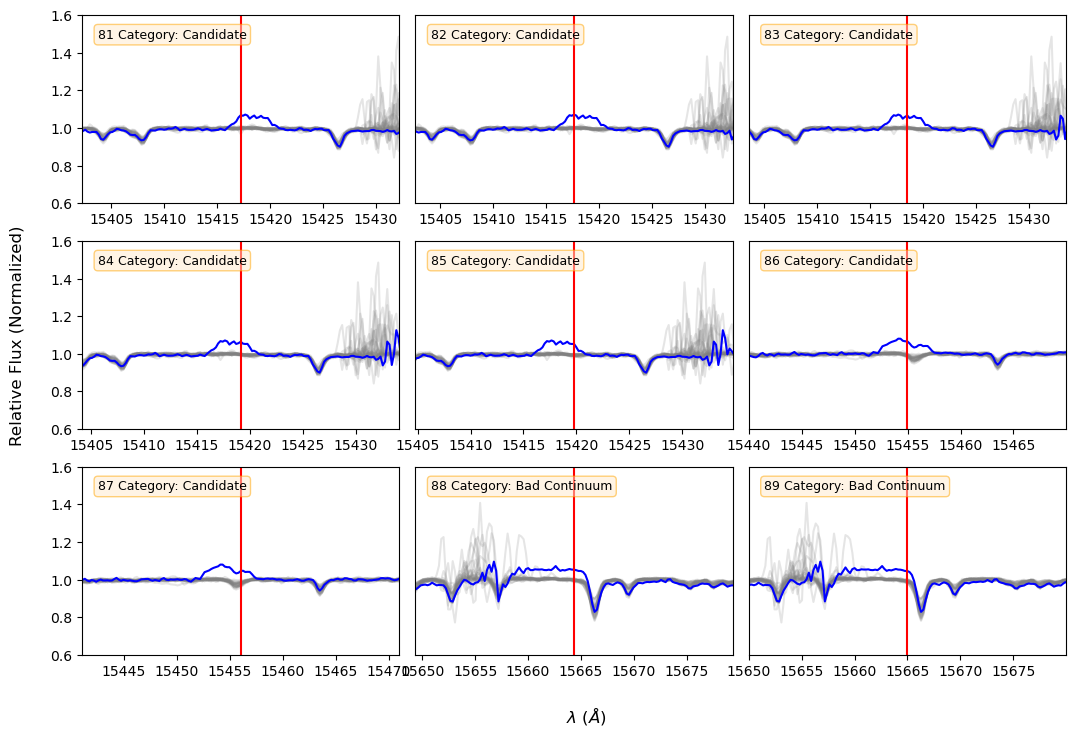

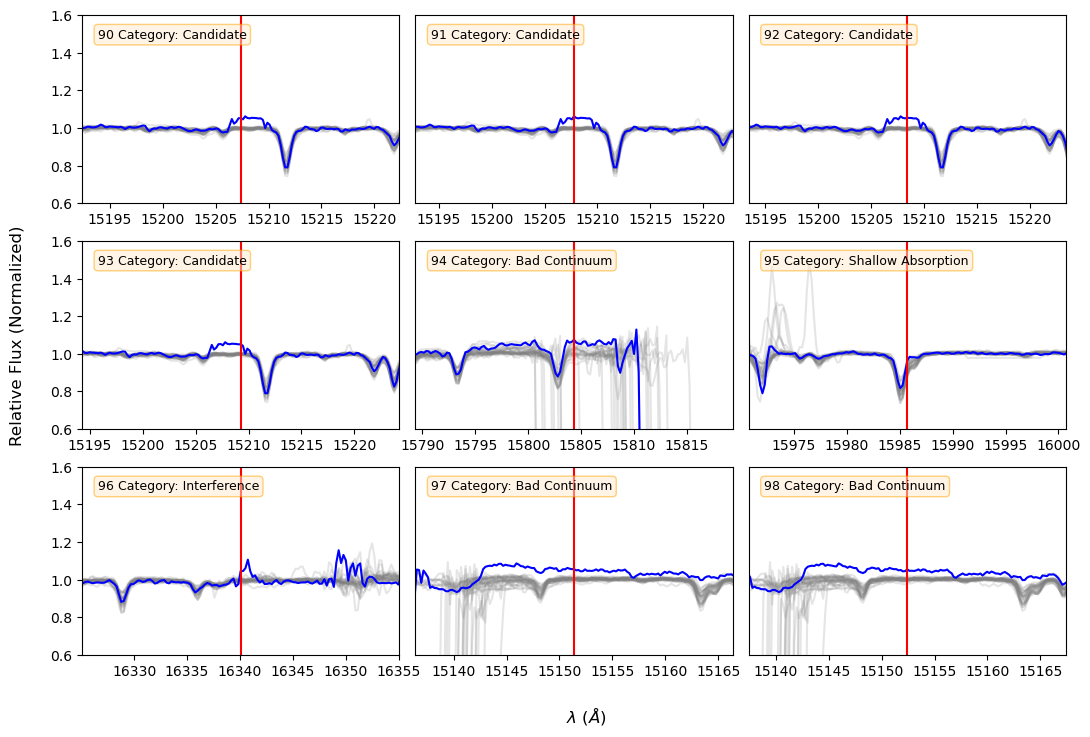

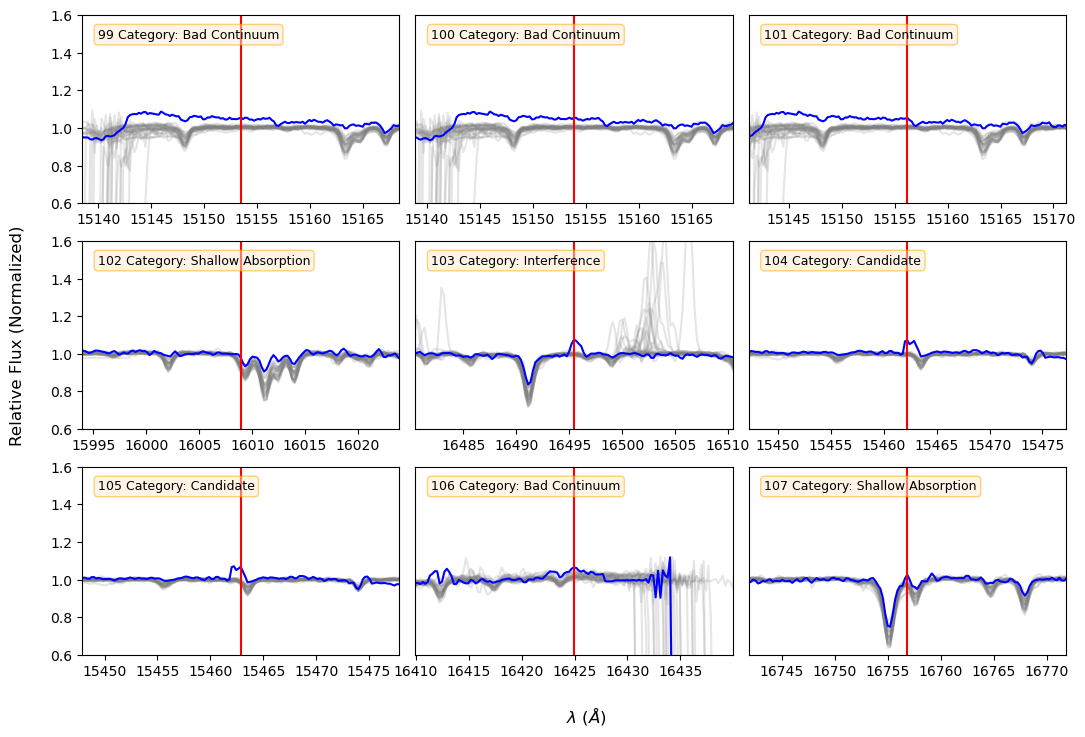

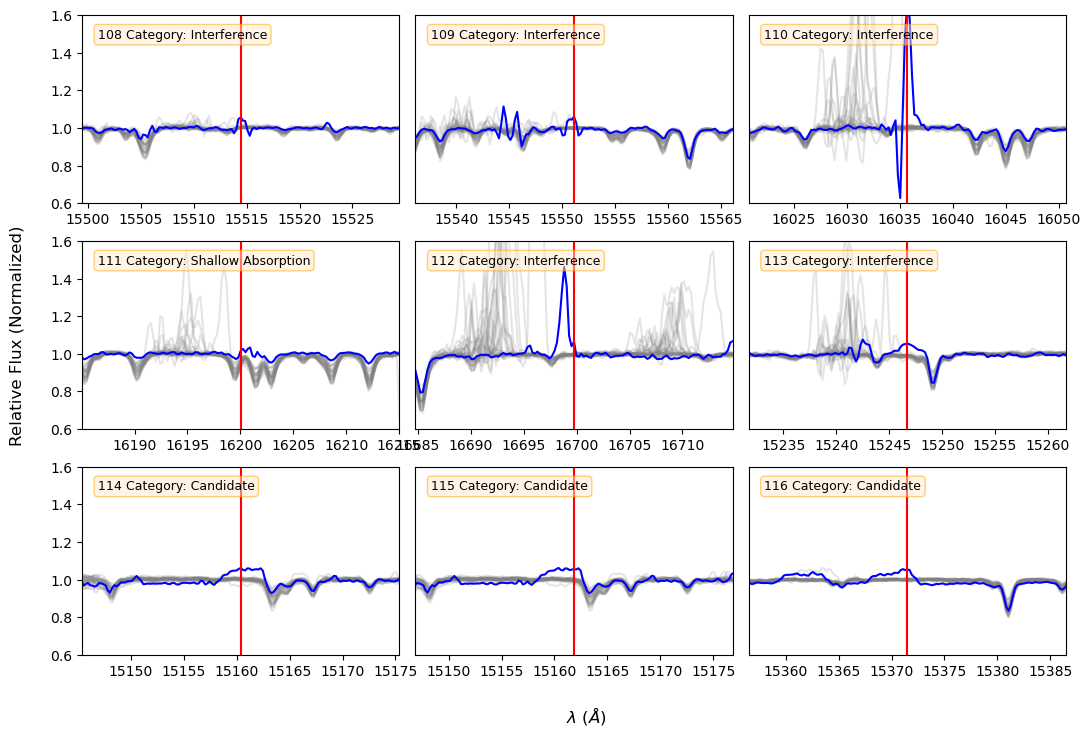

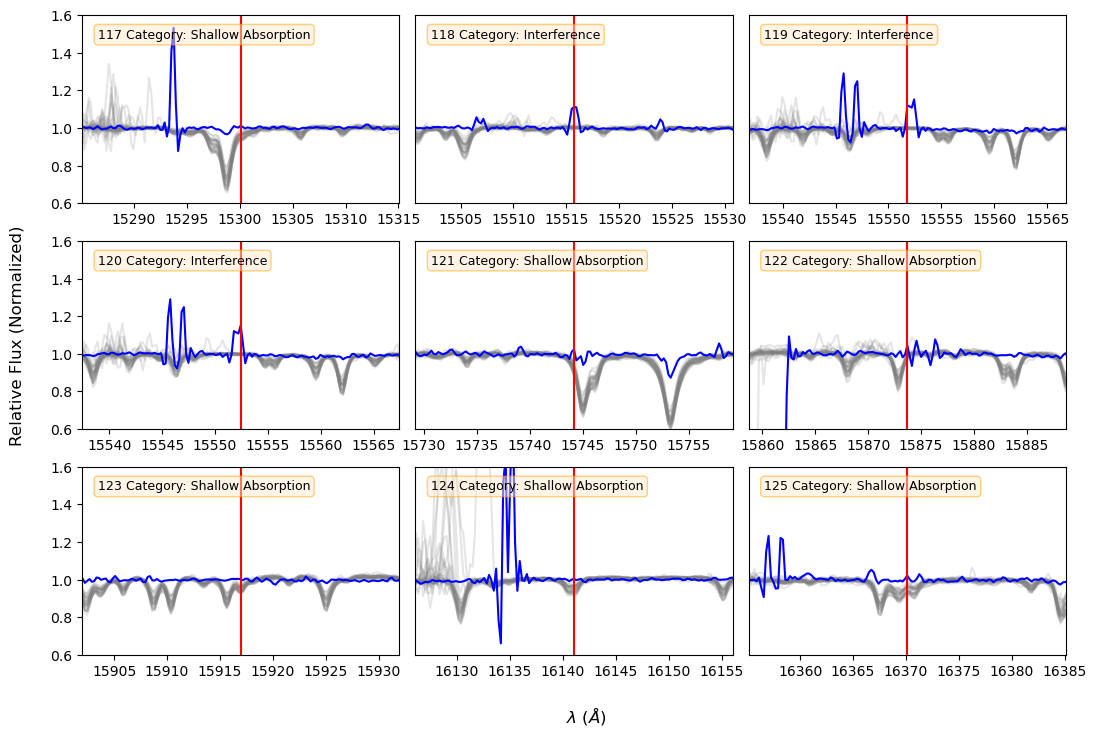

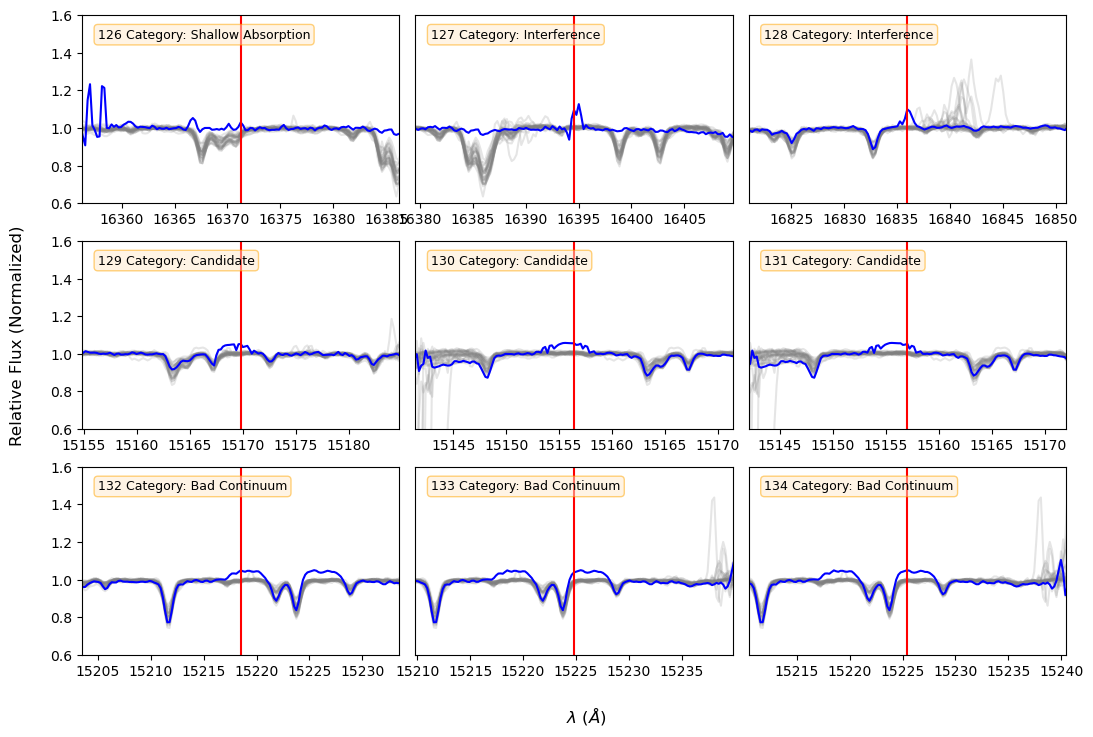

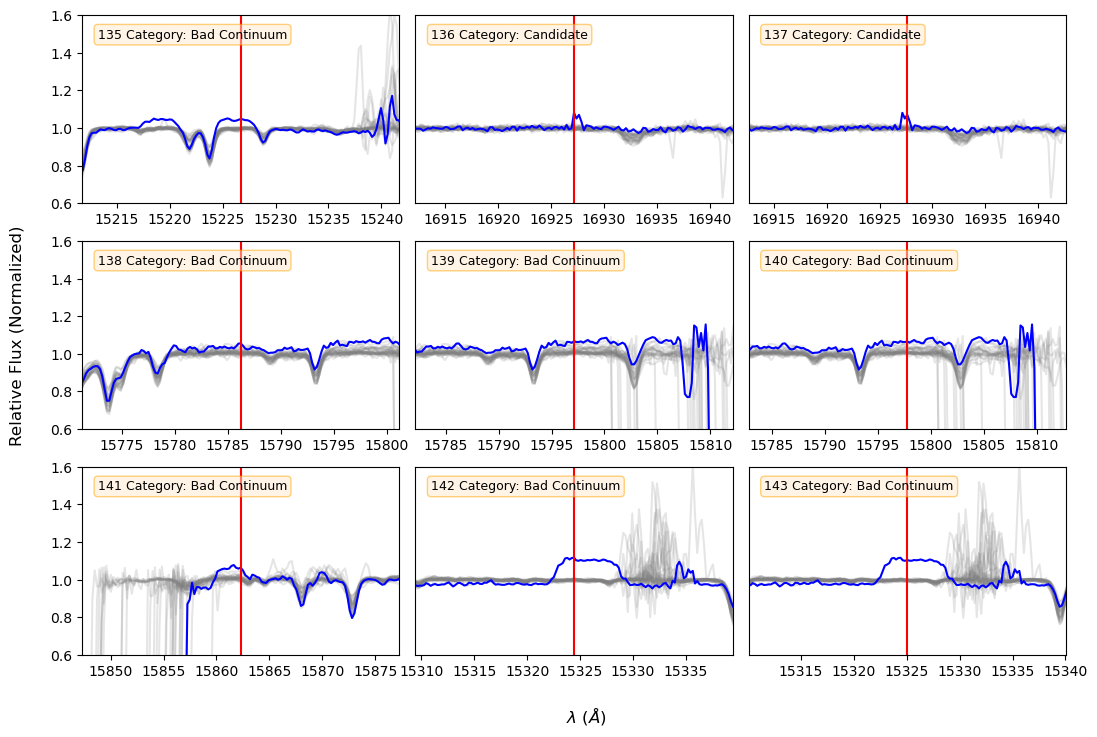

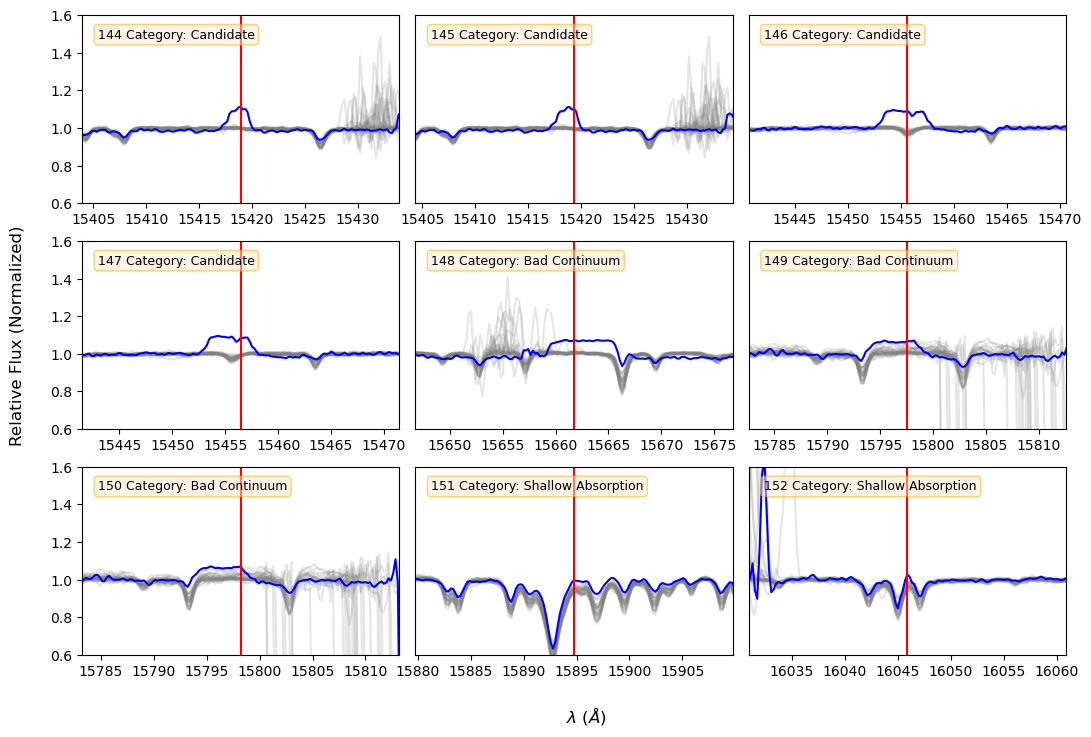

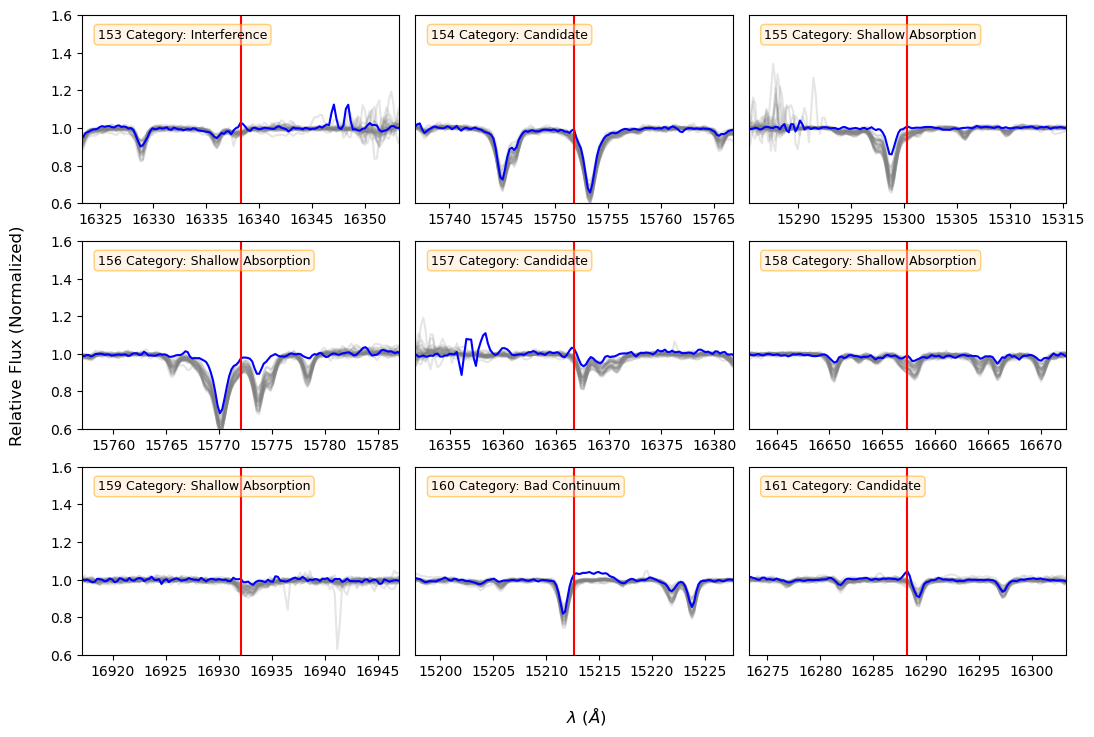

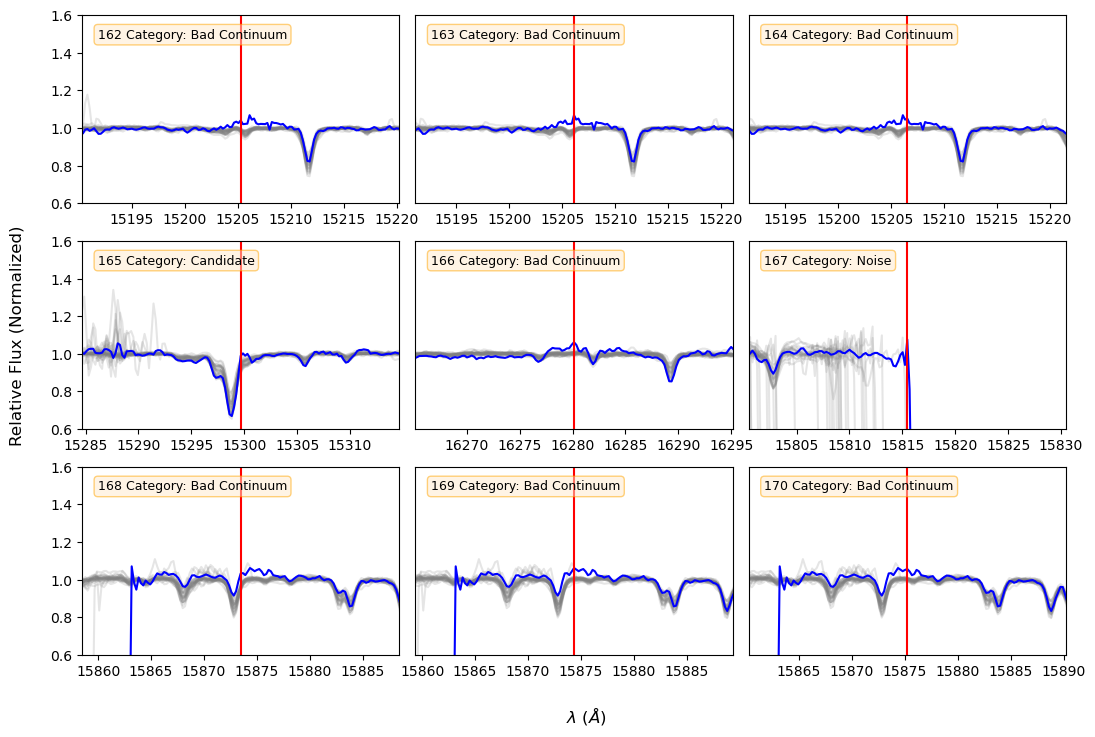

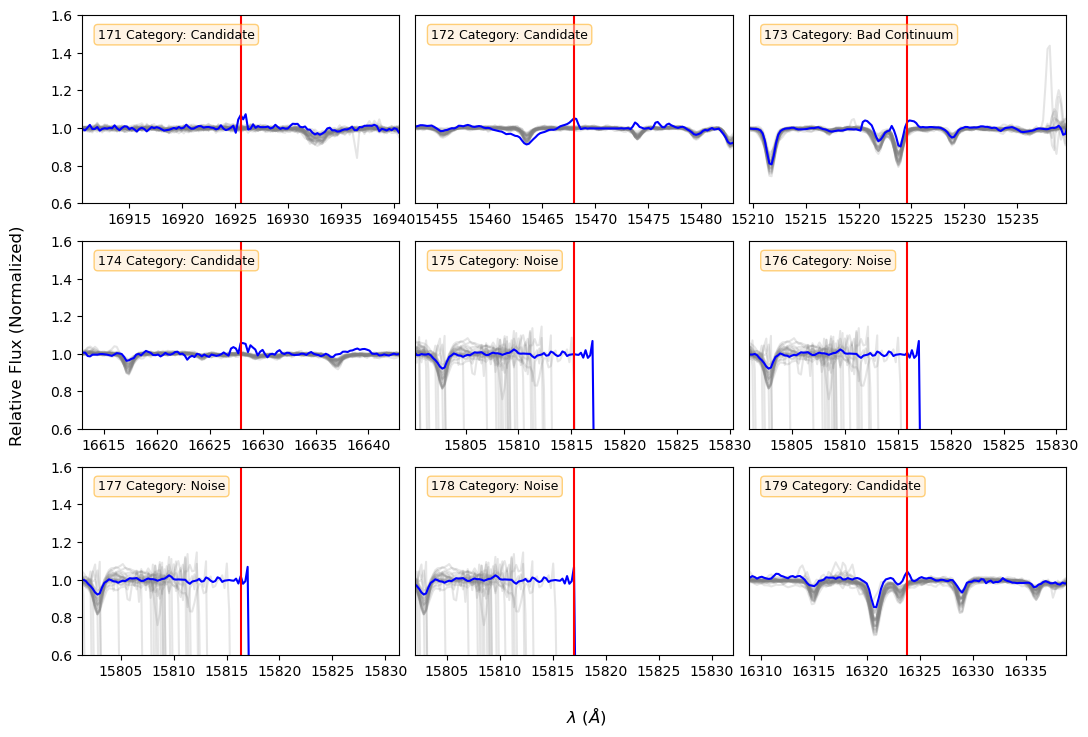

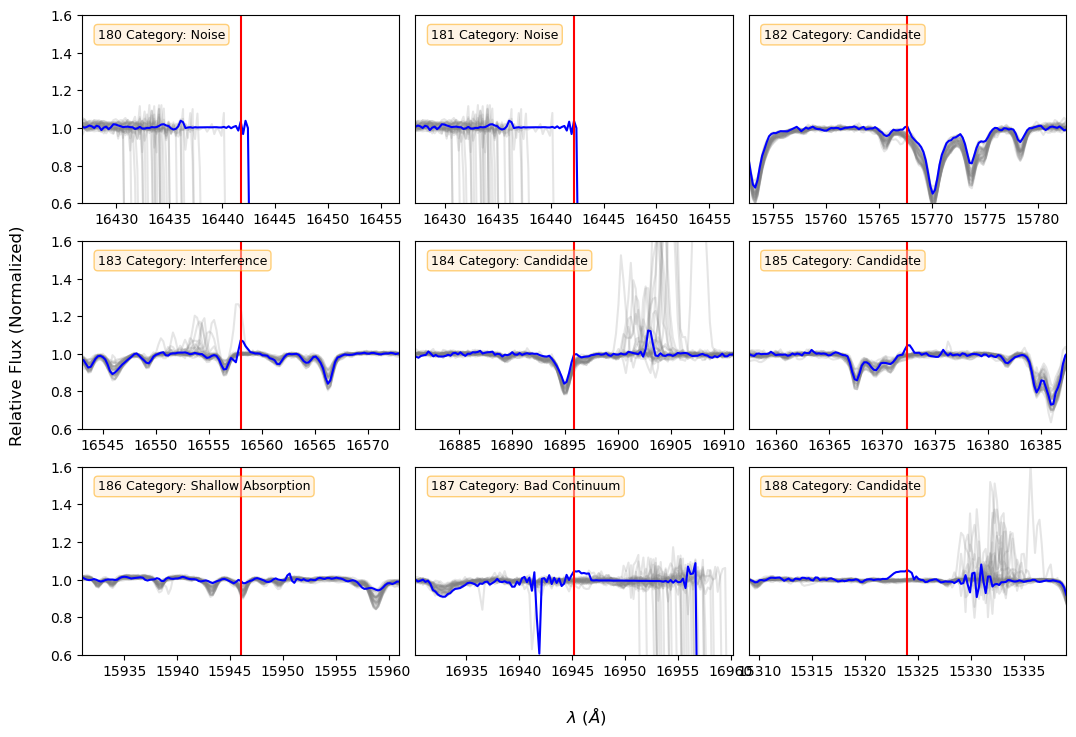

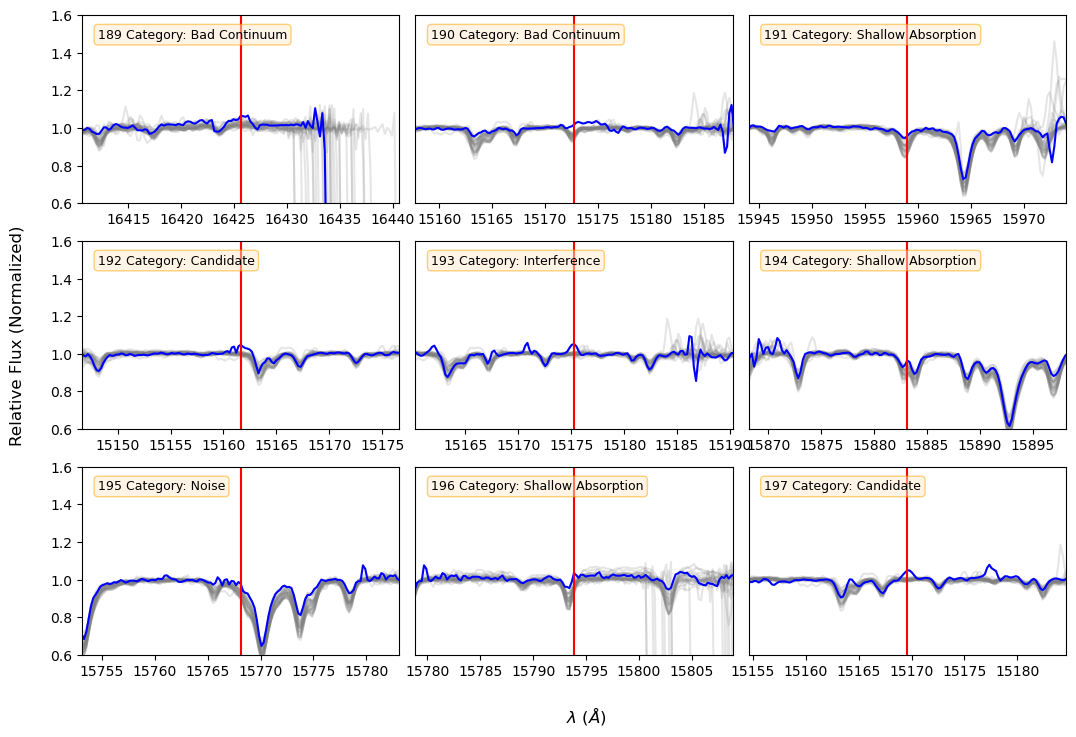

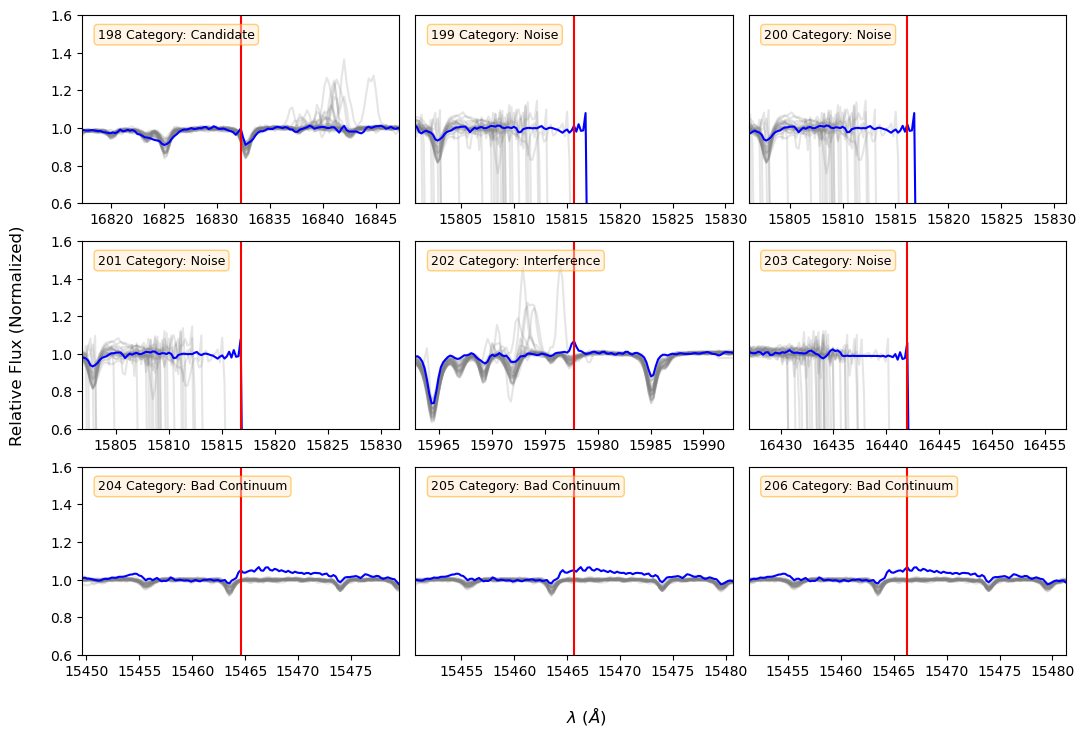

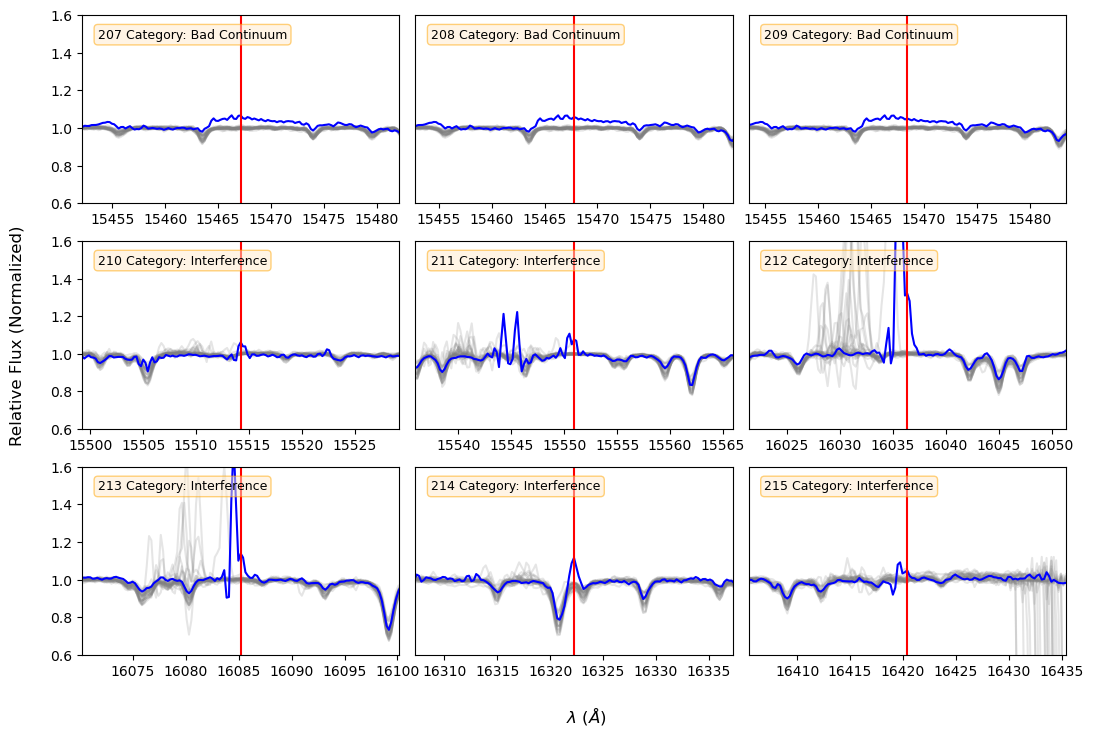

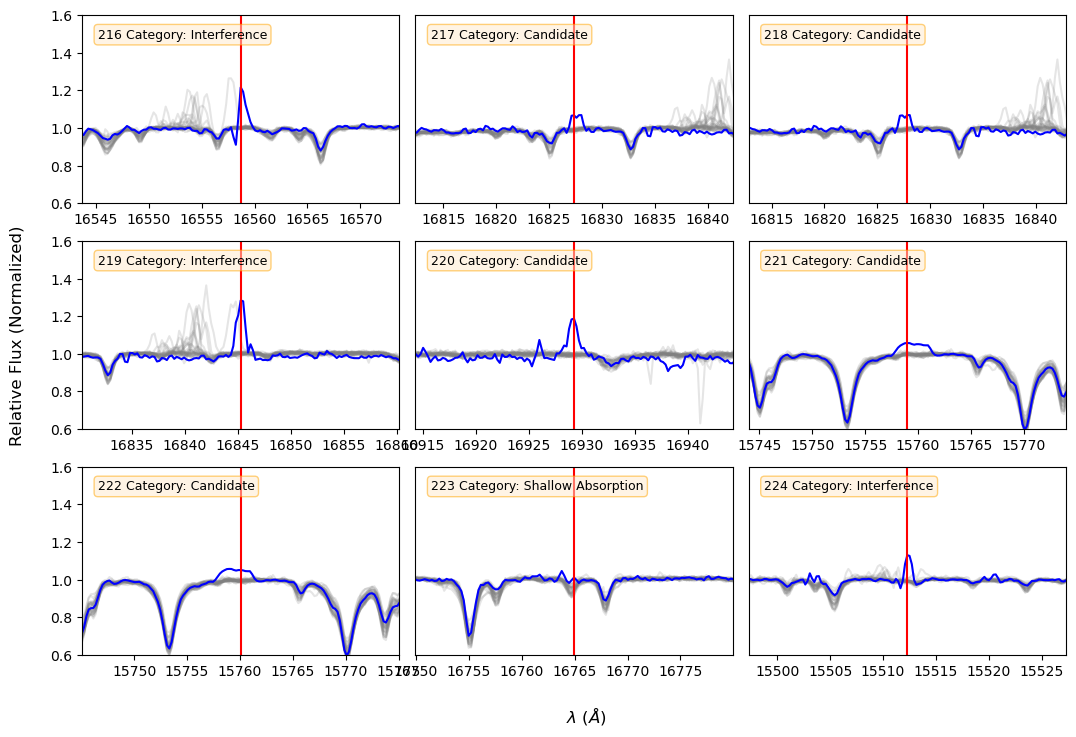

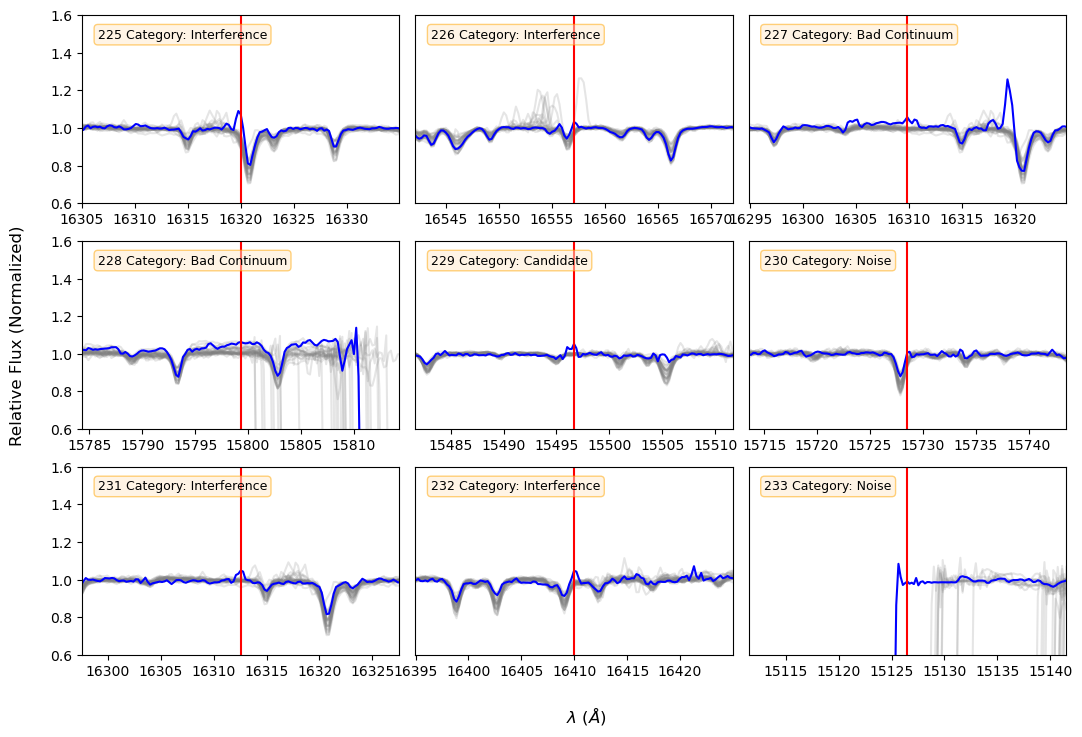

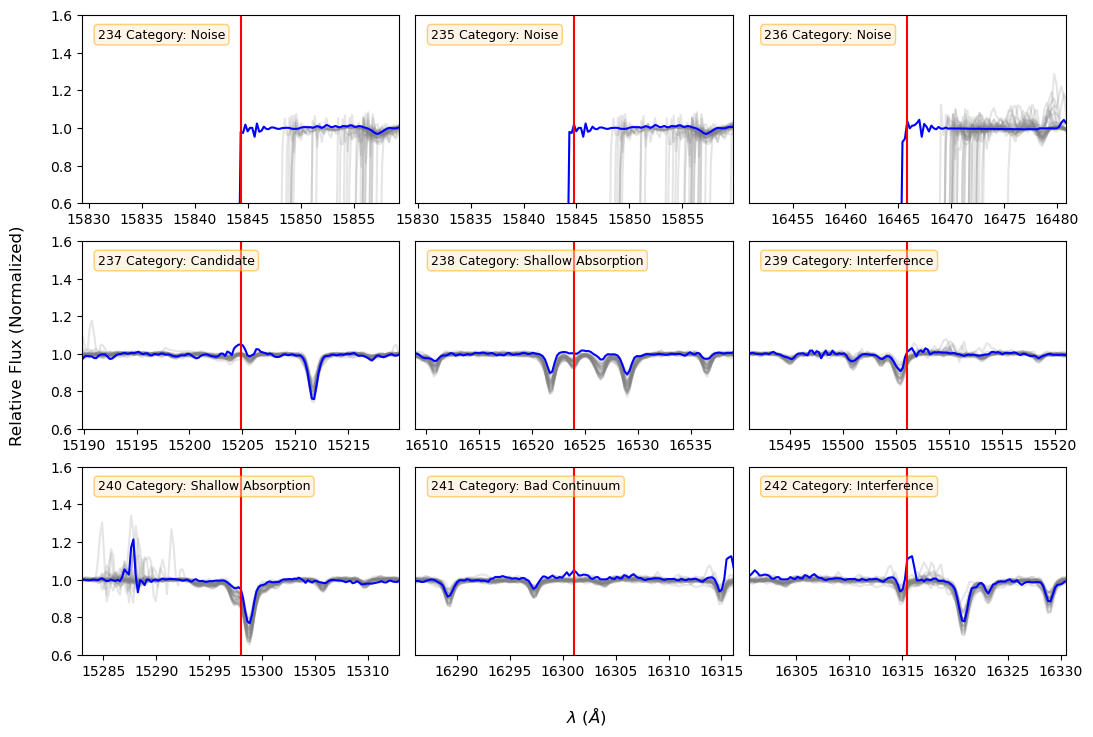

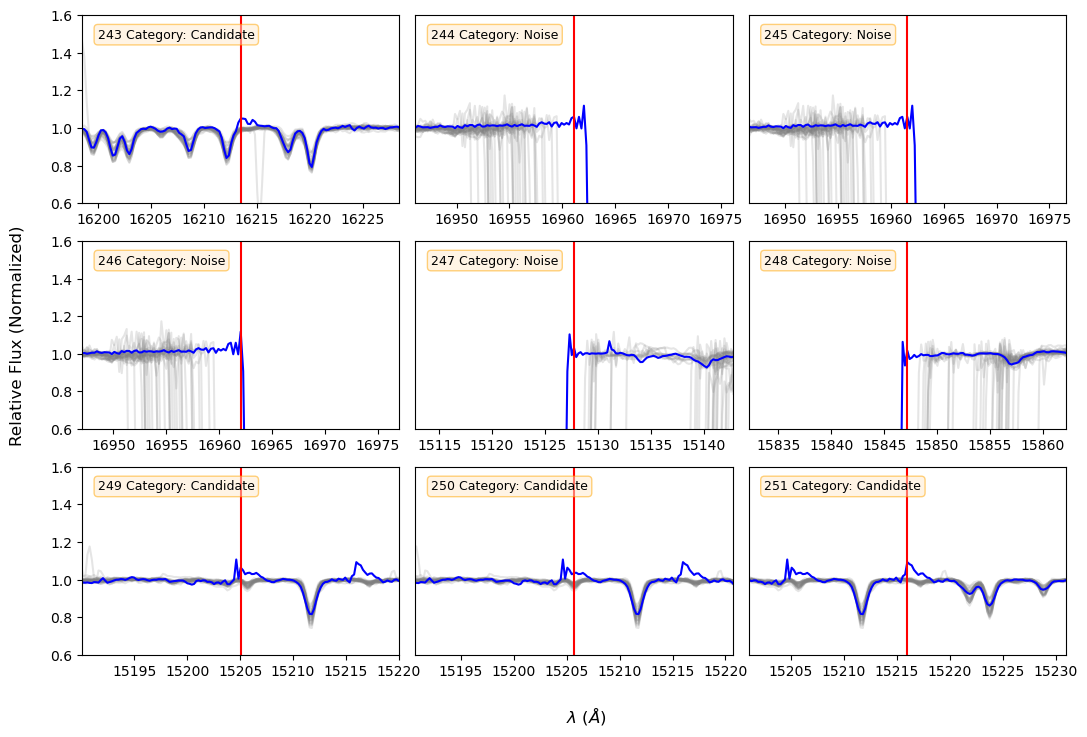

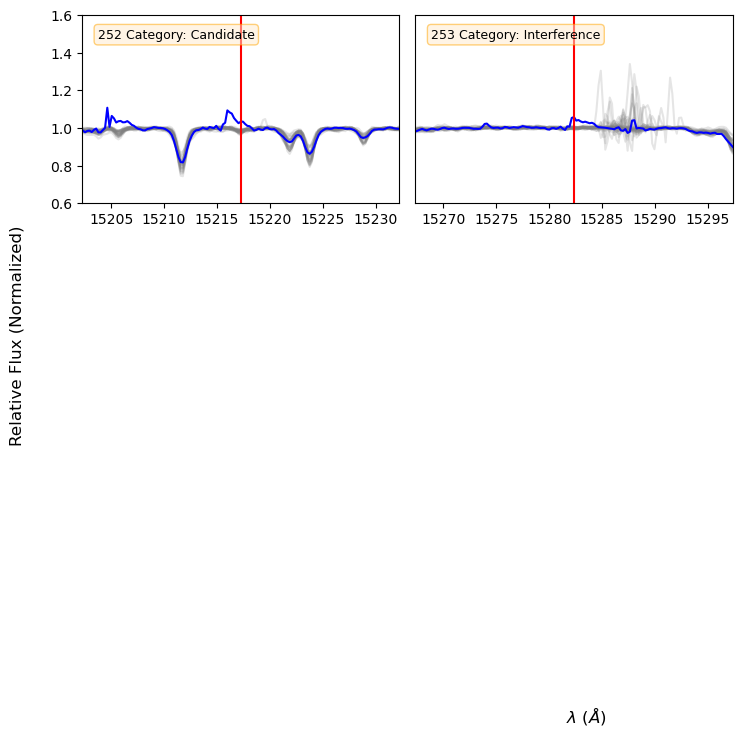

In [68]:
for j in range(0,int(len(candidates)/9 + 1)):

    fig = plt.figure(figsize=(12,8))
    
    gs = gridspec.GridSpec(3, 3, left=0.08, right=0.9, bottom=0.1, top=0.9, wspace=0.05)
    
    for i in range(0,9):
        if i + 9*j >= len(candidates):
            break
        
        ax = fig.add_subplot(gs[int(i/3), i%3])
        n = i + 9*j
        spec_id = int(candidates[n,0])

        wave = ds.wave[candidates[n,1]]
        
        ax.plot(ds.wave, norm_flux[0:30].T, alpha=0.2, color='gray')
        ax.plot(ds.wave, norm_flux[int(candidates[n,0])], color='blue')
        ax.plot((wave, wave), (0,2), color='red')
        
        ax.set_xlim(wave - 15, wave + 15)
        ax.set_ylim(0.6, 1.6)
        #stats = '%s\n$D = %.fpc$\n$T_{eff} = %.fK$\n$\log g = %.2f$' % (table['APOGEE_ID'][spec_id], table['GAIAEDR3_R_LO_PHOTOGEO'][spec_id], table['TEFF'][spec_id], table['LOGG'][spec_id])
        stats = '%d Category: %s' % (n, category_names[categories[n]-1])
        bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
        ax.text(0.05, 0.93, stats, fontsize=9, bbox=bbox,
                transform=ax.transAxes, horizontalalignment='left', verticalalignment='top')
    
        if i%3 > 0:
            ax.set_yticks([])
    
    fig.supxlabel(r'$\lambda$ ($\AA$)')
    fig.supylabel(r'Relative Flux (Normalized)')

    fig.savefig('../data/candidates/sheet_%d.png' % j)

TODO: Make this reproducible.

# How the Categorization is Performed

The categorization is based on several factors: the shape, size, and location of the emission feature.

If a feature is located very close to other emission lines from the other spectra (in gray), then it is likely an atmospheric emission line that is shared between most, if not all, of the spectra. These have their own category.

If a feature is located near the edge of a CCD boundary and is sufficiently weak and narrow, then is is classified as noise.

If a feature is not an emission feature, but was merely classified as so due to it overlapping with an unusually weak, or even absent, absorption feature, then it is classified as such.

Lastly, if the feature is very wide or is very weak and lies in a region that was poorly continuum normalized, then it is classified as such.

In [14]:
class1 = "55522111133412555534515311111134414433432113311551111555545533555515522234421111111111112211112352222235114355535511135553333335511122221122242211112223334333332144444422211314444144151131123315333144445422222255555551151113555241351444412132514444411115"
class2 = "55522111133412555534522311111134413433432113311551111555555533555555522232221111111111112211112352222235112355535511135553333335511111111122211111112223311331332111111422211114444144151132122315341114445422222255555551151113555221155444413332514444411115"
class3 = "55522111133413555533522311111134455433432513311551111555555533555555533312222222211111112211112352222235112355555522235553533335522222221122222211112223351131332522212455511214444544151132122355344514445422222255555551151113555225455444413532514444411112"

In [33]:
changes = {}
manual = []

for i in range(len(class1)):
    c1 = class1[i]
    c2 = class2[i]
    c3 = class3[i]
    if not c1 == c2 or not c2 == c3:
        if c1 == c2 or c1 == c3:
            changes[i] = c1
        elif c2 == c3:
            changes[i] = c2
        else:
            manual.append(i)
    else:
        changes[i] = c1

In [43]:
changes

{0: '5',
 1: '5',
 2: '5',
 3: '2',
 4: '2',
 5: '1',
 6: '1',
 7: '1',
 8: '1',
 9: '3',
 10: '3',
 11: '4',
 12: '1',
 13: '2',
 14: '5',
 15: '5',
 16: '5',
 17: '5',
 18: '3',
 19: '4',
 20: '5',
 21: '2',
 22: '2',
 23: '3',
 24: '1',
 25: '1',
 26: '1',
 27: '1',
 28: '1',
 29: '1',
 30: '3',
 31: '4',
 32: '4',
 33: '1',
 35: '4',
 36: '3',
 37: '3',
 38: '4',
 39: '3',
 40: '2',
 41: '1',
 42: '1',
 43: '3',
 44: '3',
 45: '1',
 46: '1',
 47: '5',
 48: '5',
 49: '1',
 50: '1',
 51: '1',
 52: '1',
 53: '5',
 54: '5',
 55: '5',
 56: '5',
 57: '5',
 58: '5',
 59: '5',
 60: '3',
 61: '3',
 62: '5',
 63: '5',
 64: '5',
 65: '5',
 66: '5',
 67: '5',
 68: '5',
 69: '2',
 70: '2',
 71: '2',
 72: '3',
 73: '2',
 74: '2',
 75: '2',
 76: '1',
 77: '1',
 78: '1',
 79: '1',
 80: '1',
 81: '1',
 82: '1',
 83: '1',
 84: '1',
 85: '1',
 86: '1',
 87: '1',
 88: '2',
 89: '2',
 90: '1',
 91: '1',
 92: '1',
 93: '1',
 94: '2',
 95: '3',
 96: '5',
 97: '2',
 98: '2',
 99: '2',
 100: '2',
 101: '2'

In [37]:
for i in manual:
    print('%d: %s %s %s' % (i, class1[i], class2[i], class3[i]))

34: 4 3 5
141: 4 1 2
153: 3 1 5
162: 4 1 2
163: 4 1 2
164: 4 1 2
166: 4 1 2
173: 3 1 2
196: 3 1 4
230: 3 1 4
239: 1 3 5


In [38]:
manual_changes = {
    34: 3,
    141: 2,
    153: 5,
    162: 2,
    163: 2,
    164: 2,
    166: 2,
    173: 2,
    196: 3,
    230: 4,
    239: 5
}

In [44]:
changes.update(manual_changes)

class_final = { k:int(v) for k,v in changes.items() }

In [45]:
class_final

{0: 5,
 1: 5,
 2: 5,
 3: 2,
 4: 2,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 3,
 10: 3,
 11: 4,
 12: 1,
 13: 2,
 14: 5,
 15: 5,
 16: 5,
 17: 5,
 18: 3,
 19: 4,
 20: 5,
 21: 2,
 22: 2,
 23: 3,
 24: 1,
 25: 1,
 26: 1,
 27: 1,
 28: 1,
 29: 1,
 30: 3,
 31: 4,
 32: 4,
 33: 1,
 35: 4,
 36: 3,
 37: 3,
 38: 4,
 39: 3,
 40: 2,
 41: 1,
 42: 1,
 43: 3,
 44: 3,
 45: 1,
 46: 1,
 47: 5,
 48: 5,
 49: 1,
 50: 1,
 51: 1,
 52: 1,
 53: 5,
 54: 5,
 55: 5,
 56: 5,
 57: 5,
 58: 5,
 59: 5,
 60: 3,
 61: 3,
 62: 5,
 63: 5,
 64: 5,
 65: 5,
 66: 5,
 67: 5,
 68: 5,
 69: 2,
 70: 2,
 71: 2,
 72: 3,
 73: 2,
 74: 2,
 75: 2,
 76: 1,
 77: 1,
 78: 1,
 79: 1,
 80: 1,
 81: 1,
 82: 1,
 83: 1,
 84: 1,
 85: 1,
 86: 1,
 87: 1,
 88: 2,
 89: 2,
 90: 1,
 91: 1,
 92: 1,
 93: 1,
 94: 2,
 95: 3,
 96: 5,
 97: 2,
 98: 2,
 99: 2,
 100: 2,
 101: 2,
 102: 3,
 103: 5,
 104: 1,
 105: 1,
 106: 2,
 107: 3,
 108: 5,
 109: 5,
 110: 5,
 111: 3,
 112: 5,
 113: 5,
 114: 1,
 115: 1,
 116: 1,
 117: 3,
 118: 5,
 119: 5,
 120: 5,
 121: 3,
 122: 3,
 123: 3,
 1

In [61]:
category_names = ['Candidate', 'Bad Continuum', 'Shallow Absorption', 'Noise', 'Interference']

categories = [ class_final[i] for i in range(len(class1)) ]

In [63]:
for i in range(len(categories)):
    print(category_names[categories[i] - 1])

Interference
Interference
Interference
Bad Continuum
Bad Continuum
Candidate
Candidate
Candidate
Candidate
Shallow Absorption
Shallow Absorption
Noise
Candidate
Bad Continuum
Interference
Interference
Interference
Interference
Shallow Absorption
Noise
Interference
Bad Continuum
Bad Continuum
Shallow Absorption
Candidate
Candidate
Candidate
Candidate
Candidate
Candidate
Shallow Absorption
Noise
Noise
Candidate
Shallow Absorption
Noise
Shallow Absorption
Shallow Absorption
Noise
Shallow Absorption
Bad Continuum
Candidate
Candidate
Shallow Absorption
Shallow Absorption
Candidate
Candidate
Interference
Interference
Candidate
Candidate
Candidate
Candidate
Interference
Interference
Interference
Interference
Interference
Interference
Interference
Shallow Absorption
Shallow Absorption
Interference
Interference
Interference
Interference
Interference
Interference
Interference
Bad Continuum
Bad Continuum
Bad Continuum
Shallow Absorption
Bad Continuum
Bad Continuum
Bad Continuum
Candidate
Candidat

In [69]:
# Last corrections to classifications
sanity_check = {
    19: 1,
    33: 5,
    43: 5,
    77: 2,
    78: 2,
    79: 2,
    80: 2,
    81: 2,
    82: 2,
    83: 2,
    84: 2,
    85: 2,
    86: 2,
    87: 2,
    114: 2,
    115: 2,
    116: 2,
    122: 5,
    152: 1,
    154: 5,
    161: 5,
    179: 5,
    226: 3,
    253: 2
}

In [71]:
for k,v in sanity_check.items():
    categories[k] = v

In [103]:
# Star ID -> candidates[:,0]
# Wavelength -> candidate_chars[:,0]
# Amplitude -> candidate_chars[:,1]
# Width? -> candidate_chars[:,2]
# Classification -> categories

candidates_final_all = np.concatenate(([candidates[:,0],],candidate_chars.T,[categories,])).T

In [106]:
import pandas as pd

dataframe = pd.DataFrame(data=candidates_final_all,
             index=range(len(candidates)),
             columns=('SPEC_IDX', 'WAVELENGTH', 'AMPLITUDE', 'FWHM', 'CLASS'))

In [107]:
dataframe.to_csv('candidates.csv')